## Process Outline
* Pull FERC Plants & Fuel tables, merge them together & sum fuel values per plant.
* Pull EIA MCOE values on a per-generator basis.
* Define masks for each of FERC & EIA that allow us to isolate the records of interest.
* Filter the big FERC & EIA tables using those masks to get the relevant plant & generator records.
* Now we have the "raw data" that will be listed as the sources information for the summary table (with some column renaming and/or dropping).
* Merging the two tables together for the purpose of summarizing per plant or per unit costs is the hard part.
* FERC Ownership:
  * Sum up all the various ownership slices from different respondents on each plant.
  * Simplifies the data, and gives a per-plant picture in the summary output.
  * May need to do some magic here to compensate for e.g. partial ownership reporting with a plant like Rodemacher (70% public, 30% private)
* Each EIA generator record needs an ID that says which FERC plant it should be associated with.
* When there's data only in one of the two data sources, that's okay -- we will do an outer merge. But each record still needs to have one of these IDs associated with it.
* For each record there are a few ways that data from the two data sources can be combined:
  1. One EIA generator maps cleanly to one FERC plant -- easy!
  2. Several EIA generators are represented by a single FERC plant owned by one respondent.
  3. Several EIA generators are represented by a single FERC plant owned by several respondents.
* For each summary record we have several cases to address:
  1. We have data for the plant from both FERC (plant) & EIA (generator). In this case, each EIA generator gets the same FERC data associated with it, but each generator keeps its own ID.
  2. We only have data from FERC (e.g. before 2009). In this case, the only ID we have is the FERC plant.
  3. We only have data from EIA (e.g. public plants). In this case, we have only the EIA fields.
* For each generator, for each year, we need to have a record. Many of them may have some null data, but that's okay -- it just won't plot.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import init, mcoe, analysis, settings, outputs
import pudl.constants as pc
import pudl.extract.ferc1

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [3]:
# For some reason these things don't stick if they're in the same cell as the
# %matplotlib inline call above, but if they're separate, they work fine.
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 56

In [4]:
def get_ces_eia(pudl_out, cols=[]):
    eia_df = pudl_out.mcoe()
    eia_df['report_year'] = eia_df.report_date.dt.year
    eia_df.rename(columns={'operator_name': 'utility_name',
                           'operator_id': 'utility_id'}, inplace=True)
    if cols is not []:
        eia_df['ces_label'] = ''
        eia_df = eia_df[cols]
    return(eia_df)

In [5]:
def get_ces_ferc(cols=[]):
    """
    Extract FERC dataframes and massage for CES usage.
     * Pull plants & fuel tables from the PUDL DB.
     * Calculate some aggregate values from the fuel table.
     * Merge the aggregated fuel data with the plants table.
     * Remove the columns that we don't want in the output.
    """
    plants_steam_ferc1 = pudl.outputs.plants_steam_ferc1()
    fuel_ferc1 = pudl.outputs.fuel_ferc1()
    ferc_gb_cols = ['report_year', 'respondent_id', 'plant_name']
    fuel_ferc1_agg = fuel_ferc1.groupby(ferc_gb_cols).agg({
        'fuel_consumed_total_cost_mmbtu': sum,
        'fuel_consumed_total_mmbtu': sum
    })

    fuel_ferc1_agg.rename(columns={'fuel_consumed_total_cost_mmbtu': 'total_fuel_cost',
                                   'fuel_consumed_total_mmbtu': 'total_mmbtu'}, inplace=True)
    fuel_ferc1_agg.reset_index(inplace=True)
    ferc_df = pd.merge(plants_steam_ferc1, fuel_ferc1_agg, on=ferc_gb_cols)
    ferc_df.rename(columns={'total_capacity_mw': 'nameplate_capacity_mw',
                             'respondent_name': 'utility_name',
                             'respondent_id': 'utility_id'}, inplace=True)

    # Calculate some derived values:
    ferc_df['capacity_factor'] = ferc_df.net_generation_mwh/(ferc_df.nameplate_capacity_mw*8760)
    ferc_df['heat_rate_mmbtu_mwh'] = ferc_df.total_mmbtu/ferc_df.net_generation_mwh
    ferc_df['fuel_cost_per_mwh'] = ferc_df.expns_fuel/ferc_df.net_generation_mwh
    ferc_df['expns_nonfuel'] = ferc_df.expns_production_total-ferc_df.expns_fuel
    ferc_df['expns_nonfuel_per_mwh'] = ferc_df.expns_nonfuel/ferc_df.net_generation_mwh
     # Rename the FERC columns to play nice with the EIA dataframe & outputs...
    ferc_df.rename(columns={'total_capacity_mw': 'nameplate_capacity_mw',
                            'respondent_name': 'utility_name',
                            'respondent_id': 'utility_id'}, inplace=True)
    if cols is not []:
        ferc_df = ferc_df[cols]
    return(ferc_df)

In [6]:
def mask_plants(plant_df, masks, label_df, src_label, out_label):
    plants_out = pd.DataFrame()
    for target in masks.keys():
        tmp_df = plant_df[masks[target]].copy()
        tmp_df[src_label] = target
        plants_out = pd.concat([plants_out, tmp_df])
    plants_out = pd.merge(plants_out, label_df[[src_label, out_label]], on=src_label)    
    plants_out = plants_out.drop_duplicates()
    return(plants_out)

In [7]:
def fix_ferc(df):
    df = df.copy()

    fixes = []
    # Scale all years of Rodemacher capacity down to reflect Cleco's 30% ownership:
    fixes.append({'gens': ['rodemacher'],
                  'col': 'nameplate_capacity_mw',
                  'years': range(2004, 2017),
                  'mult': 0.3})
    # 2010-2011 total_mmbtu off by 500x for lacygne_2_kcpl, not clear why.
    fixes.append({'gens': ['lacygne_2_kcpl'],
                  'col': 'total_mmbtu',
                  'years': [2010, 2011],
                  'mult': 1.0})
    # 2010-2011 total_mmbtu off by 300x for lacygne_1_kcpl, not clear why.
    fixes.append({'gens': ['lacygne_1_kcpl'],
                  'col': 'total_mmbtu',
                  'years': [2010, 2011],
                  'mult': 1.0})
    # 2014 net generation for PNM San Juan reported off by a factor of 10...
    fixes.append({'gens': ['san_juan_psnm'],
                  'col': 'net_generation_mwh',
                  'years': [2014],
                  'mult': 10.0})
    fixes.append({'gens': ['harrison'],
                  'col': 'net_generation_mwh',
                  'years': [2015, 2016],
                  'mult': 1000.0})
    # A similar data reporting error exists for jm_stuart's DPL numbers, in 2015 only.    
    fixes.append({'gens': ['jm_stuart_dpl'],
                  'col': 'net_generation_mwh',
                  'years': [2015],
                  'mult': 1000.0})
    fixes.append({'gens': ['killen_dpl'],
                  'col': 'net_generation_mwh',
                  'years': [2015],
                  'mult': 1000.0})
    # mult = 700 is required to maake colstrip_nwc look correct. Not clear why.
    fixes.append({'gens': ['colstrip_nwc'],
                  'col': 'total_mmbtu',
                  'years': [2004],
                  'mult': 1.0})
    # mult = 3400 required to make colstrip_nwc look right in 2008. Not clear why
    fixes.append({'gens': ['colstrip_nwc'],
                  'col': 'total_mmbtu',
                  'years': [2008],
                  'mult': 1.0})
    # mult = 700 is required to maake jim_bridger_idpc look correct in 2006. Not clear why.
    fixes.append({'gens': ['jim_bridger_idpc'],
                  'col': 'total_mmbtu',
                  'years': [2006],
                  'mult': 1.0})
    df = ferc_multiply(df, fixes)
    #df = df.drop(df[(ferc_df['plant_name'] == 'Big Stone') &
    #            (df['report_year']== 2007) &
    #            (df['utility_id'] == 122)])
    return(df)

In [8]:
def ferc_multiply(df, fixes):
    df = df.copy()
    for f in fixes:
        fix_mask = ((df.ferc_label.isin(f['gens'])) &
                    (df.report_year.isin(f['years'])))
        df.loc[fix_mask, f['col']] =  df.loc[fix_mask, f['col']].copy() * f['mult']
    return(df)

In [9]:
def agg_ferc_by_ces(ferc_df):
    ferc_ces_gb = ferc_df.groupby(['ces_label','report_year'])
    ferc_by_ces = ferc_ces_gb.agg({'net_generation_mwh': sum,
                                   'expns_nonfuel': sum,
                                   'expns_fuel': sum,
                                   'total_mmbtu': sum,
                                   'nameplate_capacity_mw': sum})
    ferc_by_ces = ferc_by_ces.reset_index()

    ferc_by_ces = ferc_by_ces.set_index(['ces_label','report_year'])
    ferc_by_ces['expns_nonfuel_per_mwh'] = ferc_by_ces['expns_nonfuel'] / ferc_by_ces['net_generation_mwh']
    ferc_by_ces['expns_fuel_per_mwh'] = ferc_by_ces['expns_fuel'] / ferc_by_ces['net_generation_mwh']
    ferc_by_ces['heat_rate_mmbtu_mwh'] = ferc_by_ces['total_mmbtu'] / ferc_by_ces['net_generation_mwh']
    ferc_by_ces['capacity_factor'] = ferc_by_ces['net_generation_mwh'] / (8760*ferc_by_ces['nameplate_capacity_mw'])
    ferc_by_ces.replace([np.inf, -np.inf], np.nan)
    return(ferc_by_ces)

In [10]:
def merge_for_ces(ferc_df, eia_df):
    ferc_by_ces = agg_ferc_by_ces(ferc_df)
    eia_by_ces = eia_df.set_index(['ces_label', 'report_year'])
    all_by_ces = pd.merge(ferc_by_ces, eia_by_ces,
                          suffixes=('_ferc','_eia'), how='outer',
                          left_index=True, right_index=True)
    all_by_ces['total_cost_per_mwh_ferc'] = \
        all_by_ces.expns_fuel_per_mwh + \
        all_by_ces.expns_nonfuel_per_mwh
    all_by_ces['total_cost_per_mwh_ferc_plus_eia'] = \
        all_by_ces.fuel_cost_per_mwh + \
        all_by_ces.expns_nonfuel_per_mwh

    year = pd.DataFrame(all_by_ces.loc[all_by_ces['report_date'].isna(), 'report_date'])
    year['year'] = year.index.get_level_values('report_year')
    year = year.drop(columns=['report_date'])
    all_by_ces.loc[all_by_ces['report_date'].isna(), 'report_date'] = pd.to_datetime({'year':year['year'],
                                                                                      'month':1,
                                                                                      'day':1})
    # drop all                                                                                 
    all_by_ces = all_by_ces.replace([np.inf, -np.inf], np.nan)
    # DROP 2007 respondent id 122 for big stone
    return(all_by_ces)

In [11]:
# TRYING TO FIGURE OUT HOW TO DROP THE 'BAD' RECORD
#ferc_df = ferc_df.drop
#(ferc_df[(ferc_df['plant_name'] == 'Big Stone') &
#                     (ferc_df['report_year'] == 2007) &
#                     (ferc_df['utility_id'] == 122)])#.index)

In [12]:
ces_eia_cols = [
    'report_date',
    'report_year',
    'plant_id_eia',
    'plant_id_pudl',
    'unit_id_pudl',
    'generator_id',
    'plant_name',
    'utility_id',
    'util_id_pudl',
    'utility_name',
    
    'state',
    'latitude',
    'longitude',
    'iso_rto_code',
    'balancing_authority_code',
    'balancing_authority_name',
    'fuel_type_pudl',
    'nameplate_capacity_mw',
    'planned_retirement_date',
    
    'capacity_factor',
    'heat_rate_mmbtu_mwh',
    'fuel_cost_per_mwh',
    
    'net_generation_mwh',
    'total_mmbtu',
    'total_fuel_cost'
]

In [13]:
# these are the columns we actually want to keep in our output.
ces_ferc_cols = [
    'report_year',
    'utility_id',
    'utility_name',
    'plant_id_pudl',
    'plant_name',
    'year_installed',
    'avg_num_employees',
    'expns_boiler',
    'expns_coolants',
    'expns_electric',
    'expns_engineering',
    'expns_fuel',
    'expns_nonfuel',
    'total_mmbtu',
    'expns_misc_power',
    'expns_misc_steam',
    'expns_operations',
    'expns_per_mwh',
    'expns_plants',
    'expns_production_total',
    'expns_rents',
    'expns_steam',
    'expns_steam_other',
    'expns_structures',
    'expns_transfer',
    'net_generation_mwh',
    'nameplate_capacity_mw',
]

## Data Extraction & Processing Begins Here

In [14]:
# Keeping this part separate from the function call, since it can be time consuming if we are
# re-calculating the MCOE dataset over and over again.
pudl_out = pudl.outputs.PudlOutput(freq='MS')

In [15]:
eia_df = get_ces_eia(pudl_out, cols=ces_eia_cols)
ferc_df = get_ces_ferc(cols=ces_ferc_cols)

## Enumerate the FERC & EIA selectors/masks
* For each CES target plant, create a set of EIA & FERC masks that extract the relevant records from our dataframes.
* On the EIA side, they'll potentially include several generators.
* On the FERC side, they'll potentially include several ownership slices.
* Each generator (EIA) or ownership slice (FERC) will have its own mask, and get its own label.
* Each mask will also be associated with a single CES label. That label will allow the FERC & EIA dataframes to be merged appropriately, such that each FERC label matches

In [16]:
# This dataframe defines the connections between the CES (output), EIA
# and FERC labels for each of the plants, so we can join the datasets
# together appropriately. The eia_label column contains values that 
# correspond to the eia_masks dictionary keys. The ferc_label column
# similarly corresponds to the ferc_masks keys, and the ces_label
# column is used to label the output records in the summary sheet, as
# well as to join the FERC & EIA dataframes together.
labelcols=['ces_label','ferc_label','eia_label']
ces_label_df = pd.DataFrame(columns=labelcols)
eia_masks = {}
ferc_masks = {}

######################################################################
# 1.) RODEMACHER / BRAME ENERGY CENTER
######################################################################
eia_masks['rodemacher'] = ((eia_df.plant_id_eia==6190) &
                           (eia_df.unit_id_pudl==2))
ferc_masks['rodemacher'] = (ferc_df.plant_name.str.match('.*odemach.*2'))

# Create the mapping between CES (output), FERC & EIA (input) records
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('rodemacher', 'rodemacher', 'rodemacher'),
], columns=labelcols))

######################################################################
# 2.) OKLAUNION
######################################################################
eia_masks['oklaunion'] = (eia_df.plant_id_eia==127)
ferc_masks['oklaunion_psok'] = ((ferc_df.plant_name.str.match('.*klaunion.*')) &
                                (ferc_df.utility_id==148))
ferc_masks['oklaunion_aeptx_north'] = ((ferc_df.plant_name.str.match('.*klaunion.*')) &
                                       (ferc_df.utility_id==189))
ferc_masks['oklaunion_aeptx_central'] = ((ferc_df.plant_name.str.match('.*klaunion.*')) &
                                         (ferc_df.utility_id==24))

# Create the mapping between CES (output), FERC & EIA (input) records
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('oklaunion', 'oklaunion_psok', 'oklaunion'),
    ('oklaunion', 'oklaunion_aeptx_north', 'oklaunion'),
    ('oklaunion', 'oklaunion_aeptx_central', 'oklaunion'),
], columns=labelcols))

######################################################################
# 3.) HOLCOMB (publicly owned, no FERC)
######################################################################
eia_masks['holcomb'] = (eia_df.plant_id_eia==108)
# Create the mapping between CES (output), FERC & EIA (input) records
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('holcomb', '', 'holcomb'),
], columns=labelcols))

######################################################################
# 4.) JEFFREY
######################################################################
eia_masks['jeffrey_1'] = ((eia_df.plant_id_eia==6068) &
                         (eia_df.unit_id_pudl==1))
eia_masks['jeffrey_2'] = ((eia_df.plant_id_eia==6068) &
                         (eia_df.unit_id_pudl==2))
eia_masks['jeffrey_3'] = ((eia_df.plant_id_eia==6068) &
                         (eia_df.unit_id_pudl==3))

ferc_masks['jeffrey_westar'] = ((ferc_df.plant_name.str.match('.*effrey.*')) &
                                (ferc_df.utility_id==191) &
                                (ferc_df.expns_fuel > 0.0))
ferc_masks['jeffrey_ksgeco'] = ((ferc_df.plant_name.str.match('.*effrey.*')) &
                                (ferc_df.utility_id==80) &
                                (ferc_df.expns_fuel > 0.0))
ferc_masks['jeffrey_kcpl'] = ((ferc_df.plant_name.str.match('.*effrey.*')) &
                              (ferc_df.utility_id==182) &
                              (ferc_df.expns_fuel > 0.0))

# Create the mapping between CES (output), FERC & EIA (input) records
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('jeffrey_1', 'jeffrey_westar', 'jeffrey_1'),
    ('jeffrey_1', 'jeffrey_ksgeco', 'jeffrey_1'),
    ('jeffrey_1', 'jeffrey_kcpl', 'jeffrey_1'),
    ('jeffrey_2', 'jeffrey_westar', 'jeffrey_2'),
    ('jeffrey_2', 'jeffrey_ksgeco', 'jeffrey_2'),
    ('jeffrey_2', 'jeffrey_kcpl', 'jeffrey_2'),
    ('jeffrey_3', 'jeffrey_westar', 'jeffrey_3'),
    ('jeffrey_3', 'jeffrey_ksgeco', 'jeffrey_3'),
    ('jeffrey_3', 'jeffrey_kcpl', 'jeffrey_3'),
], columns=labelcols))
######################################################################
# 5.) GERALD GENTLEMAN (publicly owned, no FERC)
######################################################################
eia_masks['gerald_gentleman_1'] = ((eia_df.plant_id_eia==6077) &
                                  (eia_df.unit_id_pudl==1))
eia_masks['gerald_gentleman_2'] = ((eia_df.plant_id_eia==6077) &
                                  (eia_df.unit_id_pudl==2))

# Create the mapping between CES (output), FERC & EIA (input) records
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('gerald_gentleman_1', '', 'gerald_gentleman_1'),
    ('gerald_gentleman_2', '', 'gerald_gentleman_2'),
], columns=labelcols))

######################################################################
# 6.) LA CYGNE
######################################################################
eia_masks['lacygne_1'] = ((eia_df.plant_id_eia==1241) &
                         (eia_df.unit_id_pudl==1))
eia_masks['lacygne_2'] = ((eia_df.plant_id_eia==1241) &
                         (eia_df.unit_id_pudl==2))

ferc_masks['lacygne_1_kcpl'] = (
    (ferc_df.plant_name.str.match('(La Cygne 50%|Lacygne 50%|Lacygne 1.*)')) &
    (ferc_df.utility_id==79)
)
ferc_masks['lacygne_2_kcpl'] = ((ferc_df.plant_name.str.match('.*ygne.*2.*')) &
                               (ferc_df.utility_id==79))
ferc_masks['lacygne_1_kge'] = ((ferc_df.plant_name.str.match('.*ygne.*#1.*')) &
                              (ferc_df.utility_id==80))
ferc_masks['lacygne_2_kge'] = ((ferc_df.plant_name.str.match('.*ygne.*#2.*')) &
                              (ferc_df.utility_id==80))

# Create the mapping between CES (output), FERC & EIA (input) records
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('lacygne_1', 'lacygne_1_kcpl', 'lacygne_1'),
    ('lacygne_1', 'lacygne_1_kge', 'lacygne_1'),
    ('lacygne_2', 'lacygne_2_kcpl', 'lacygne_2'),
    ('lacygne_2', 'lacygne_2_kge', 'lacygne_2'),
], columns=labelcols))

######################################################################
# 7.) SIBLEY
######################################################################
eia_masks['sibley_1'] = ((eia_df.plant_id_eia==2094) &
                         (eia_df.unit_id_pudl==1))
eia_masks['sibley_2'] = ((eia_df.plant_id_eia==2094) &
                         (eia_df.unit_id_pudl==2))
eia_masks['sibley_3'] = ((eia_df.plant_id_eia==2094) &
                         (eia_df.unit_id_pudl==3))

ferc_masks['sibley'] = ((ferc_df.utility_id==182) &
                        (ferc_df.plant_name=='Sibley'))

# Create the mapping between CES (output), FERC & EIA (input) records
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('sibley_1', 'sibley', 'sibley_1'),
    ('sibley_2', 'sibley', 'sibley_2'),
    ('sibley_3', 'sibley', 'sibley_3'),
], columns=labelcols))

######################################################################
# 8.) NEBRASKA CITY (publicly owned, no FERC)
######################################################################
eia_masks['nebraska_city_1'] = ((eia_df.plant_id_eia==6096) &
                               (eia_df.unit_id_pudl==1))
eia_masks['nebraska_city_2'] = ((eia_df.plant_id_eia==6096) &
                               (eia_df.unit_id_pudl==2))

# Create the mapping between CES (output), FERC & EIA (input) records
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('nebraska_city_1', '', 'nebraska_city_1'),
    ('nebraska_city_2', '', 'nebraska_city_2'),
], columns=labelcols))
######################################################################
# 9.) SOONER (publicly owned, no FERC)
######################################################################
eia_masks['sooner_1'] = ((eia_df.plant_id_eia==6095) &
                        (eia_df.unit_id_pudl==1))
eia_masks['sooner_2'] = ((eia_df.plant_id_eia==6095) &
                        (eia_df.unit_id_pudl==2))
# Create the mapping between CES (output), FERC & EIA (input) records
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('sooner_1', '', 'sooner_1'),
    ('sooner_2', '', 'sooner_2'),
], columns=labelcols))

######################################################################
# 10.) GEORGE NEAL 
######################################################################
eia_masks['george_neal_1'] = ((eia_df.plant_id_eia==1091) &
                             (eia_df.unit_id_pudl==1))

eia_masks['george_neal_2'] = ((eia_df.plant_id_eia==1091) &
                             (eia_df.unit_id_pudl==2))

eia_masks['george_neal_3'] = ((eia_df.plant_id_eia==1091) &
                             (eia_df.unit_id_pudl==3))

ferc_masks['george_neal_1'] = ((ferc_df.plant_name.str.match('.*Neal.*1')))
ferc_masks['george_neal_2'] = ((ferc_df.plant_name.str.match('.*Neal.*2')))

ferc_masks['george_neal_3_ipl'] = (
    (ferc_df.plant_name.str.match('.*Neal.*3') &
    (ferc_df.utility_id==281)))
ferc_masks['george_neal_3_midam'] = (
    (ferc_df.plant_name.str.match('.*Neal.*3') &
    (ferc_df.utility_id==210)))

# Create the mapping between CES (output), FERC & EIA (input) records
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('george_neal_1', 'george_neal_1', 'george_neal_1'),
    ('george_neal_2', 'george_neal_2', 'george_neal_2'),
    ('george_neal_3', 'george_neal_3_ipl', 'george_neal_3'),
    ('george_neal_3', 'george_neal_3_midam', 'george_neal_3'),
], columns=labelcols))

###########################################################################
# San Juan Generation Station
eia_masks['san_juan_1'] = ((eia_df.plant_id_eia==2451) &
                          (eia_df.unit_id_pudl==1))
eia_masks['san_juan_2'] = ((eia_df.plant_id_eia==2451) &
                          (eia_df.unit_id_pudl==2))
eia_masks['san_juan_3'] = ((eia_df.plant_id_eia==2451) &
                          (eia_df.unit_id_pudl==3))
eia_masks['san_juan_4'] = ((eia_df.plant_id_eia==2451) &
                          (eia_df.unit_id_pudl==4))

ferc_masks['san_juan_psnm'] = ((ferc_df.plant_name.str.match('.*[Ss]an [Jj]uan.*')) &
                               (ferc_df.utility_id==147))
ferc_masks['san_juan_tepco'] = ((ferc_df.plant_name.str.match('.*[Ss]an [Jj]uan.*')) &
                                (ferc_df.utility_id==176))
# Create the mapping between CES (output), FERC & EIA (input) records
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('san_juan_1', 'san_juan_psnm', 'san_juan_1'),
    ('san_juan_1', 'san_juan_tepco', 'san_juan_1'),
    ('san_juan_2', 'san_juan_psnm', 'san_juan_2'),
    ('san_juan_2', 'san_juan_tepco', 'san_juan_2'),
    ('san_juan_3', 'san_juan_psnm', 'san_juan_3'),
    ('san_juan_3', 'san_juan_tepco', 'san_juan_3'),
    ('san_juan_4', 'san_juan_psnm', 'san_juan_4'),
    ('san_juan_4', 'san_juan_tepco', 'san_juan_4'),
], columns=labelcols))

###########################################################################
# BEGIN THE PJM PLANTS
#pjm_targets = eia_df[(eia_df.report_year >= 2015) &
#       (eia_df.fuel_type_pudl=='coal') &
#       (eia_df.balancing_authority_code=='PJM') &
#       (eia_df.capacity_factor <= 0.60) &
#       (eia_df.fuel_cost_per_mwh > 20.0) &
#       (eia_df.nameplate_capacity_mw > 100.0) ].\
#    sort_values('fuel_cost_per_mwh', ascending=False)[eia_simple_cols].\
#    drop_duplicates(['plant_id_eia', 'unit_id_pudl'])
#done_plants = [3809, 3797, 3809, 3797, 6166, 3954, 1384, 3948,
#               56808, 6041, 6018, 3944, 3935, 6031, 2850]
#pjm_targets[~pjm_targets.plant_id_eia.isin(done_plants)]
###########################################################################

###########################################################################
# Yorktown
eia_masks['yorktown_1'] = ((eia_df.plant_id_eia==3809) &
                           (eia_df.unit_id_pudl==1))
eia_masks['yorktown_2'] = ((eia_df.plant_id_eia==3809) &
                           (eia_df.unit_id_pudl==2))
eia_masks['yorktown_3'] = ((eia_df.plant_id_eia==3809) &
                           (eia_df.unit_id_pudl==3))
ferc_masks['yorktown'] = (ferc_df.plant_name.str.match('.*orktown.*'))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('yorktown_1', 'yorktown', 'yorktown_1'),
    ('yorktown_2', 'yorktown', 'yorktown_2'),
    ('yorktown_3', 'yorktown', 'yorktown_3'),
], columns=labelcols))

###########################################################################
# Chesterfield
eia_masks['chesterfield_1'] = ((eia_df.plant_id_eia==3797) &
                               (eia_df.unit_id_pudl==1))
eia_masks['chesterfield_2'] = ((eia_df.plant_id_eia==3797) &
                               (eia_df.unit_id_pudl==2))
eia_masks['chesterfield_3'] = ((eia_df.plant_id_eia==3797) &
                               (eia_df.unit_id_pudl==3))
eia_masks['chesterfield_4'] = ((eia_df.plant_id_eia==3797) &
                               (eia_df.unit_id_pudl==4))
ferc_masks['chesterfield'] = (ferc_df.plant_name.str.match('Chesterfield$'))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('chesterfield_1', 'chesterfield', 'chesterfield_1'),
    ('chesterfield_2', 'chesterfield', 'chesterfield_2'),
    ('chesterfield_3', 'chesterfield', 'chesterfield_3'),
    ('chesterfield_4', 'chesterfield', 'chesterfield_4'),
], columns=labelcols))

###########################################################################
# Rockport 1 & 2
eia_masks['rockport_1'] = ((eia_df.plant_id_eia==6166) &
                           (eia_df.unit_id_pudl==1))
eia_masks['rockport_2'] = ((eia_df.plant_id_eia==6166) &
                           (eia_df.unit_id_pudl==2))
ferc_masks['rockport_aeg'] = ((ferc_df.plant_name.str.match('Rockport Total Aeg')) &
                              (ferc_df.utility_id==1))
ferc_masks['rockport_inmi'] = ((ferc_df.plant_name.str.match('Rockport Total I&M')) &
                               (ferc_df.utility_id==73))

ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('rockport_1', 'rockport_aeg', 'rockport_1'),
    ('rockport_1', 'rockport_inmi', 'rockport_1'),
    ('rockport_2', 'rockport_aeg', 'rockport_2'),
    ('rockport_2', 'rockport_inmi', 'rockport_2'),
], columns=labelcols))

###########################################################################
# Mount Storm coal plant.
eia_masks['mt_storm_1'] = ((eia_df.plant_id_eia==3954) &
                           (eia_df.unit_id_pudl==1))
eia_masks['mt_storm_2'] = ((eia_df.plant_id_eia==3954) &
                           (eia_df.unit_id_pudl==2))
eia_masks['mt_storm_3'] = ((eia_df.plant_id_eia==3954) &
                           (eia_df.unit_id_pudl==3))
ferc_masks['mt_storm'] = ((ferc_df.plant_name.str.match('Mount Storm$')) &
                          (ferc_df.utility_id==186))

ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('mt_storm_1', 'mt_storm', 'mt_storm_1'),
    ('mt_storm_2', 'mt_storm', 'mt_storm_2'),
    ('mt_storm_3', 'mt_storm', 'mt_storm_3'),
], columns=labelcols))

###########################################################################
# Cooper plant, E. KY Power Cooperative... so no FERC data.
eia_masks['cooper_1'] = ((eia_df.plant_id_eia==1384) &
                         (eia_df.unit_id_pudl==1))
eia_masks['cooper_2'] = ((eia_df.plant_id_eia==1384) &
                         (eia_df.unit_id_pudl==2))
ferc_masks['cooper'] = (ferc_df.plant_name.str.match('.*ooper.*'))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('cooper_1', '', 'cooper_1'),
    ('cooper_2', '', 'cooper_2'),
], columns=labelcols))

###########################################################################
# Mitchell (West Virginia) plant. Originally owned by Ohio Power Company,
# then split between Kentucky Power Company, and AEP, subsequently Wheeling
eia_masks['mitchell_1'] = ((eia_df.plant_id_eia==3948) &
                         (eia_df.unit_id_pudl==1))
eia_masks['mitchell_2'] = ((eia_df.plant_id_eia==3948) &
                         (eia_df.unit_id_pudl==2))
ferc_masks['mitchell_opc'] = ((ferc_df.plant_name.str.match('.*[Mm]itchell.*')) &
                              (ferc_df.utility_id==127))
ferc_masks['mitchell_kpc'] = ((ferc_df.plant_name.str.match('.*Mitchell.*Share$')) &
                              (ferc_df.utility_id==81))
ferc_masks['mitchell_aep'] = ((ferc_df.plant_name.str.match('.*Mitchell.*Share$')) &
                              (ferc_df.utility_id==452))
ferc_masks['mitchell_wpc'] = ((ferc_df.plant_name.str.match('.*Mitchell.*Share$')) &
                              (ferc_df.utility_id==192))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('mitchell_1', 'mitchell_opc', 'mitchell_1'),
    ('mitchell_2', 'mitchell_opc', 'mitchell_2'),
    ('mitchell_1', 'mitchell_kpc', 'mitchell_1'),
    ('mitchell_2', 'mitchell_kpc', 'mitchell_2'),
    ('mitchell_1', 'mitchell_aep', 'mitchell_1'),
    ('mitchell_2', 'mitchell_aep', 'mitchell_2'),
    ('mitchell_1', 'mitchell_wpc', 'mitchell_1'),
    ('mitchell_2', 'mitchell_wpc', 'mitchell_2'),
], columns=labelcols))

###########################################################################
# Virginia City Hybrid Energy Center. Has 2 units, burns lots of different
# kinds of stuff (but mostly coal). Unfortuantely, many of the individual
# months of data from EIA that feed into Virginia City have NA values in 
# them, which means we've got almost no annual level data available. Maybe
# we should look at the plants on a monthly basis, or figure out a way to
# average over the good months. See:
# https://github.com/catalyst-cooperative/pudl/issues/160
eia_masks['virginia_city_1'] = ((eia_df.plant_id_eia==56808) &
                         (eia_df.unit_id_pudl==1))
eia_masks['virginia_city_2'] = ((eia_df.plant_id_eia==56808) &
                         (eia_df.unit_id_pudl==2))
ferc_masks['virginia_city'] = ((ferc_df.plant_name.str.match('.*irginia [Cc]ity.*')))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('virginia_city_1', 'virginia_city', 'virginia_city_1'),
    ('virginia_city_2', 'virginia_city', 'virginia_city_2')
], columns=labelcols))

###########################################################################
# Spurlock is a Co-op plant, and so has no FERC data.
# Unit 1: missing 2013 & 2015 data (due to NA values?)
# Unit 2: missing 2015 data (due to NA values?)
eia_masks['hl_spurlock_1'] = ((eia_df.plant_id_eia==6041) &
                              (eia_df.unit_id_pudl==1))
eia_masks['hl_spurlock_2'] = ((eia_df.plant_id_eia==6041) &
                              (eia_df.unit_id_pudl==2))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('hl_spurlock_1', '', 'hl_spurlock_1'),
    ('hl_spurlock_2', '', 'hl_spurlock_2')
], columns=labelcols))

###########################################################################
# East Bend -- Ownership of Duke's share seems to have moved from one
# subsidiary to another. Also, why is only generator_id=2 showing up in EIA?
# Seems like another case of some bad NA values.
eia_masks['east_bend'] = ((eia_df.plant_id_eia==6018) &
                          (eia_df.unit_id_pudl==1))
ferc_masks['east_bend_dukeoh'] = ((ferc_df.plant_name.str.match('.*East Bend.*')) &
                                  (ferc_df.utility_id==27))
ferc_masks['east_bend_daypl'] = ((ferc_df.plant_name.str.match('.*East Bend.*')) &
                                 (ferc_df.utility_id==42))
ferc_masks['east_bend_dukeky'] = ((ferc_df.plant_name.str.match('.*East Bend.*')) &
                                  (ferc_df.utility_id==178))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('east_bend', 'east_bend_dukeoh', 'east_bend'),
    ('east_bend', 'east_bend_daypl', 'east_bend'),
    ('east_bend', 'east_bend_dukeky', 'east_bend'),
], columns=labelcols))

###########################################################################
# Harrison plant, owned by FirstEnergy, sold to subsidiary Mon Energy in
# 2013 -- at that point FERC reported capacity jumps to 2000MW. Only a 
# couple of complete years of cost data in EIA -- suffers from NA values.
# Last 2 years of FERC data are totally wacked -- neeeds to be cleaned up.
# Also, capacity reported doesn't really match up between EIA & FERC... we're
# missing a third unit, for which there's *no* whole year of data that's valid
# in EIA.  Gah.
eia_masks['harrison_1'] = ((eia_df.plant_id_eia==3944) &
                          (eia_df.unit_id_pudl==1))
eia_masks['harrison_2'] = ((eia_df.plant_id_eia==3944) &
                          (eia_df.unit_id_pudl==2))
eia_masks['harrison_3'] = ((eia_df.plant_id_eia==3944) &
                          (eia_df.unit_id_pudl==3))
ferc_masks['harrison'] = ((ferc_df.plant_name.str.match('.*arrison.*')) &
                                  (ferc_df.utility_id==101))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('harrison_1', 'harrison', 'harrison_1'),
    ('harrison_2', 'harrison', 'harrison_2'),
    ('harrison_3', 'harrison', 'harrison_3'),
], columns=labelcols))

###########################################################################
# John Amos plant has 3 units. Jointly owned by Appalachian Power Co & 
# Ohio Power Co until 2013, after which point it is entirely App Pwr Co.
eia_masks['amos_1'] = ((eia_df.plant_id_eia==3935) &
                            (eia_df.unit_id_pudl==1))
eia_masks['amos_2'] = ((eia_df.plant_id_eia==3935) &
                            (eia_df.unit_id_pudl==2))
eia_masks['amos_3'] = ((eia_df.plant_id_eia==3935) &
                            (eia_df.unit_id_pudl==3))
ferc_masks['amos_apco'] = ((ferc_df.plant_name.str.match('^Amos-Apco Share$')) &
                           (ferc_df.utility_id==6))
ferc_masks['amos_opco'] = ((ferc_df.plant_name.str.match('^Amos-Opco Share$')) &
                           (ferc_df.utility_id==127))
ferc_masks['amos_consolidated'] = ((ferc_df.plant_name.str.match('^Amos$')) &
                                   (ferc_df.utility_id==6))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('amos_1', 'amos_apco', 'amos_1'),
    ('amos_2', 'amos_apco', 'amos_2'),
    ('amos_3', 'amos_apco', 'amos_3'),
    ('amos_1', 'amos_opco', 'amos_1'),
    ('amos_2', 'amos_opco', 'amos_2'),
    ('amos_3', 'amos_opco', 'amos_3'),
    ('amos_1', 'amos_consolidated', 'amos_1'),
    ('amos_2', 'amos_consolidated', 'amos_2'),
    ('amos_3', 'amos_consolidated', 'amos_3'),
], columns=labelcols))

###########################################################################
# Killen is slated for retirement mid-2018.  There's a weird dangling
# 12-18 MW generator of some kind being reported to FERC, which is why the
# DPL filter includes the nameplate capacity minimum of 100.0 MW. DPL also
# has fuel costs which are off by a factor of 1000x in 2015 only.
eia_masks['killen'] = ((eia_df.plant_id_eia==6031) &
                       (eia_df.unit_id_pudl==1))
ferc_masks['killen_duke'] = ((ferc_df.plant_name.str.match('.*Killen.*')) &
                             (ferc_df.utility_id==27))
ferc_masks['killen_dpl'] = ((ferc_df.plant_name.str.match('.*Killen.*')) &
                              (ferc_df.utility_id==42) &
                              (ferc_df.nameplate_capacity_mw > 100.0))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('killen', 'killen_duke', 'killen'),
    ('killen', 'killen_dpl', 'killen'),
], columns=labelcols))

###########################################################################
# J.M. Stuart plant has 4 coal fired units, and an ownership structure that
# has changed over the years. 2015 fuel cost numbers reported by DPL are off
# by a factor of 1000x.
eia_masks['jm_stuart_1'] = ((eia_df.plant_id_eia==2850) &
                            (eia_df.unit_id_pudl==1))
eia_masks['jm_stuart_2'] = ((eia_df.plant_id_eia==2850) &
                            (eia_df.unit_id_pudl==2))
eia_masks['jm_stuart_3'] = ((eia_df.plant_id_eia==2850) &
                            (eia_df.unit_id_pudl==3))
eia_masks['jm_stuart_4'] = ((eia_df.plant_id_eia==2850) &
                            (eia_df.unit_id_pudl==4))
ferc_masks['jm_stuart_duke'] = ((ferc_df.plant_name.str.match('.*Stuart.*')) &
                                (ferc_df.utility_id==27))
ferc_masks['jm_stuart_csp'] = ((ferc_df.plant_name.str.match('.*Stuart.*')) &
                               (ferc_df.utility_id==31))
ferc_masks['jm_stuart_opco'] = ((ferc_df.plant_name.str.match('.*Stuart.*')) &
                                (ferc_df.utility_id==127))
ferc_masks['jm_stuart_aep'] = ((ferc_df.plant_name.str.match('.*Stuart.*')) &
                               (ferc_df.utility_id==452))
ferc_masks['jm_stuart_dpl'] = ((ferc_df.plant_name.str.match('.*Stuart.*')) &
                               (ferc_df.utility_id==42) &
                               (ferc_df.nameplate_capacity_mw > 100.0))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('jm_stuart_1', 'jm_stuart_duke', 'jm_stuart_1'),
    ('jm_stuart_2', 'jm_stuart_duke', 'jm_stuart_2'),
    ('jm_stuart_3', 'jm_stuart_duke', 'jm_stuart_3'),
    ('jm_stuart_4', 'jm_stuart_duke', 'jm_stuart_4'),
    ('jm_stuart_1', 'jm_stuart_csp', 'jm_stuart_1'),
    ('jm_stuart_2', 'jm_stuart_csp', 'jm_stuart_2'),
    ('jm_stuart_3', 'jm_stuart_csp', 'jm_stuart_3'),
    ('jm_stuart_4', 'jm_stuart_csp', 'jm_stuart_4'),
    ('jm_stuart_1', 'jm_stuart_opco', 'jm_stuart_1'),
    ('jm_stuart_2', 'jm_stuart_opco', 'jm_stuart_2'),
    ('jm_stuart_3', 'jm_stuart_opco', 'jm_stuart_3'),
    ('jm_stuart_4', 'jm_stuart_opco', 'jm_stuart_4'),
    ('jm_stuart_1', 'jm_stuart_aep', 'jm_stuart_1'),
    ('jm_stuart_2', 'jm_stuart_aep', 'jm_stuart_2'),
    ('jm_stuart_3', 'jm_stuart_aep', 'jm_stuart_3'),
    ('jm_stuart_4', 'jm_stuart_aep', 'jm_stuart_4'),
    ('jm_stuart_1', 'jm_stuart_dpl', 'jm_stuart_1'),
    ('jm_stuart_2', 'jm_stuart_dpl', 'jm_stuart_2'),
    ('jm_stuart_3', 'jm_stuart_dpl', 'jm_stuart_3'),
    ('jm_stuart_4', 'jm_stuart_dpl', 'jm_stuart_4'),
], columns=labelcols))

###########################################################################
# BEGIN THE COLORADO & PACIFICORP PLANTS HERE:
###########################################################################

###########################################################################
# Comanche -- down in Pueblo, CO
eia_masks['comanche_1'] = ((eia_df.plant_id_eia==470) &
                           (eia_df.unit_id_pudl==1))
eia_masks['comanche_2'] = ((eia_df.plant_id_eia==470) &
                           (eia_df.unit_id_pudl==2))
eia_masks['comanche_3'] = ((eia_df.plant_id_eia==470) &
                           (eia_df.unit_id_pudl==3))
ferc_masks['comanche'] = ((ferc_df.plant_name.str.match('Comanche')) &
                          (ferc_df.utility_id==145))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('comanche_1', 'comanche', 'comanche_1'),
    ('comanche_2', 'comanche', 'comanche_2'),
    ('comanche_3', 'comanche', 'comanche_3'),
], columns=labelcols))

###########################################################################
# Pawnee
eia_masks['pawnee'] = ((eia_df.plant_id_eia==6248) &
                         (eia_df.unit_id_pudl==1))
ferc_masks['pawnee'] = ((ferc_df.plant_name.str.match('Pawnee')) &
                        (ferc_df.utility_id==145))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('pawnee', 'pawnee', 'pawnee'),
], columns=labelcols))

###########################################################################
# Mayden 1 & 2 -- operated by PSCO, partly owned by PacifiCorp
eia_masks['hayden_1'] = ((eia_df.plant_id_eia==525) &
                          (eia_df.unit_id_pudl==1))
eia_masks['hayden_2'] = ((eia_df.plant_id_eia==525) &
                          (eia_df.unit_id_pudl==2))
ferc_masks['hayden_psco'] = ((ferc_df.plant_name.str.match('Hayden')) &
                             (ferc_df.utility_id==145))
ferc_masks['hayden_pc'] = ((ferc_df.plant_name.str.match('Hayden')) &
                           (ferc_df.utility_id==134))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('hayden_1', 'hayden_psco', 'hayden_1'),
    ('hayden_2', 'hayden_psco', 'hayden_2'),
    ('hayden_1', 'hayden_pc', 'hayden_1'),
    ('hayden_2', 'hayden_pc', 'hayden_2'),
], columns=labelcols))

###########################################################################
# Craig station is a big ownership mess...
eia_masks['craig_1'] = ((eia_df.plant_id_eia==6021) &
                        (eia_df.unit_id_pudl==1))
eia_masks['craig_2'] = ((eia_df.plant_id_eia==6021) &
                        (eia_df.unit_id_pudl==2))
eia_masks['craig_3'] = ((eia_df.plant_id_eia==6021) &
                        (eia_df.unit_id_pudl==3))
ferc_masks['craig_psco'] = ((ferc_df.plant_name.str.match('Craig')) &
                            (ferc_df.utility_id==145))
ferc_masks['craig_pc'] = ((ferc_df.plant_name.str.match('Craig')) &
                          (ferc_df.utility_id==134))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('craig_1', 'craig_psco', 'craig_1'),
    ('craig_2', 'craig_psco', 'craig_2'),
    ('craig_3', 'craig_psco', 'craig_3'),
    ('craig_1', 'craig_pc', 'craig_1'),
    ('craig_2', 'craig_pc', 'craig_2'),
    ('craig_3', 'craig_pc', 'craig_3'),
], columns=labelcols))

###########################################################################
# Rawhide is owned by PRPA, a public power entity, so no FERC data.
eia_masks['rawhide'] = ((eia_df.plant_id_eia==6761) &
                        (eia_df.unit_id_pudl==1))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('rawhide', '', 'rawhide'),
], columns=labelcols))

###########################################################################
# Martin Drake is owned by the Colorado Springs Utility, so no FERC.
eia_masks['martin_drake_1']= ((eia_df.plant_id_eia==492) & 
                              (eia_df.unit_id_pudl==1))
eia_masks['martin_drake_2']= ((eia_df.plant_id_eia==492) & 
                              (eia_df.unit_id_pudl==2))
eia_masks['martin_drake_3']= ((eia_df.plant_id_eia==492) & 
                              (eia_df.unit_id_pudl==3))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('martin_drake_1', '', 'martin_drake_1'),
    ('martin_drake_2', '', 'martin_drake_2'),
    ('martin_drake_3', '', 'martin_drake_3'),
], columns=labelcols))

###########################################################################
# Colstrip is complicated. No EIA data for some reason -- cost are all
# unreportd, but there should be other data, no? But it's all NA. I have
# included what I think the masks should be to capture those units anyway,
# in case we can fix it later or there's some real data there monthly...
# FERC ownership adds up to 1400MW in 2008 and later, but less earlier.
# Did the plant used to be largely owned by a public power entity?
eia_masks['colstrip_1']= ((eia_df.plant_id_eia==6076) & 
                          (eia_df.unit_id_pudl==1))
eia_masks['colstrip_2']= ((eia_df.plant_id_eia==6076) & 
                          (eia_df.unit_id_pudl==2))
eia_masks['colstrip_3']= ((eia_df.plant_id_eia==6076) & 
                          (eia_df.unit_id_pudl==3))
eia_masks['colstrip_4']= ((eia_df.plant_id_eia==6076) & 
                          (eia_df.unit_id_pudl==4))
ferc_masks['colstrip_nwc'] = ((ferc_df.plant_name.str.match('.*Colstrip.*')) &
                              (ferc_df.utility_id==122)) # 240 MW 2004-2016
ferc_masks['colstrip_pc'] = ((ferc_df.plant_name.str.match('.*Colstrip.*')) &
                             (ferc_df.utility_id==134)) # 155 MW 2004-2016
ferc_masks['colstrip_avista'] = ((ferc_df.plant_name.str.match('.*Colstrip.*')) &
                                 (ferc_df.utility_id==187)) # 233 MW 2004-2016
ferc_masks['colstrip_pse'] = ((ferc_df.plant_name.str.match('.*Colstrip.*')) &
                              (ferc_df.utility_id==150)) # 377 + 433 MW 2008-2016
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('colstrip_1', 'colstrip_nwc', 'colstrip_1'),
    ('colstrip_2', 'colstrip_nwc', 'colstrip_2'),
    ('colstrip_3', 'colstrip_nwc', 'colstrip_3'),
    ('colstrip_4', 'colstrip_nwc', 'colstrip_4'),
    ('colstrip_1', 'colstrip_pc', 'colstrip_1'),
    ('colstrip_2', 'colstrip_pc', 'colstrip_2'),
    ('colstrip_3', 'colstrip_pc', 'colstrip_3'),
    ('colstrip_4', 'colstrip_pc', 'colstrip_4'),
    ('colstrip_1', 'colstrip_avista', 'colstrip_1'),
    ('colstrip_2', 'colstrip_avista', 'colstrip_2'),
    ('colstrip_3', 'colstrip_avista', 'colstrip_3'),
    ('colstrip_4', 'colstrip_avista', 'colstrip_4'),
    ('colstrip_1', 'colstrip_pse', 'colstrip_1'),
    ('colstrip_2', 'colstrip_pse', 'colstrip_2'),
    ('colstrip_3', 'colstrip_pse', 'colstrip_3'),
    ('colstrip_4', 'colstrip_pse', 'colstrip_4'),
], columns=labelcols))
           
###########################################################################
# Dave Johnston
eia_masks['dave_johnston_1']= ((eia_df.plant_id_eia==4158) & 
                               (eia_df.unit_id_pudl==1))
eia_masks['dave_johnston_2']= ((eia_df.plant_id_eia==4158) & 
                               (eia_df.unit_id_pudl==2))
eia_masks['dave_johnston_3']= ((eia_df.plant_id_eia==4158) & 
                               (eia_df.unit_id_pudl==3))
eia_masks['dave_johnston_4']= ((eia_df.plant_id_eia==4158) & 
                               (eia_df.unit_id_pudl==4))
ferc_masks['dave_johnston'] = ((ferc_df.plant_name.str.match('.*Johnston.*')) &
                               (ferc_df.utility_id==134))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('dave_johnston_1', 'dave_johnston', 'dave_johnston_1'),
    ('dave_johnston_2', 'dave_johnston', 'dave_johnston_2'),
    ('dave_johnston_3', 'dave_johnston', 'dave_johnston_3'),
    ('dave_johnston_4', 'dave_johnston', 'dave_johnston_4'),
], columns=labelcols))
           
###########################################################################
# Naughton (PacifiCorp)
eia_masks['naughton_1']= ((eia_df.plant_id_eia==4162) & 
                          (eia_df.unit_id_pudl==1))
eia_masks['naughton_2']= ((eia_df.plant_id_eia==4162) & 
                          (eia_df.unit_id_pudl==2))
eia_masks['naughton_3']= ((eia_df.plant_id_eia==4162) & 
                          (eia_df.unit_id_pudl==3))
ferc_masks['naughton'] = ((ferc_df.plant_name.str.match('.*Naught.*')) &
                          (ferc_df.utility_id==134))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('naughton_1', 'naughton', 'naughton_1'),
    ('naughton_2', 'naughton', 'naughton_2'),
    ('naughton_3', 'naughton', 'naughton_3'),
], columns=labelcols))
           
###########################################################################
# Wyodak (PacifiCorp)
eia_masks['wyodak']= ((eia_df.plant_id_eia==6101) &
                      (eia_df.unit_id_pudl==3))
ferc_masks['wyodak_bhp'] = ((ferc_df.plant_name.str.match('.*Wyodak.*')) &
                            (ferc_df.utility_id==12))
ferc_masks['wyodak_pc'] = ((ferc_df.plant_name.str.match('.*Wyodak.*')) &
                            (ferc_df.utility_id==134))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('wyodak', 'wyodak_bhp', 'wyodak'),
    ('wyodak', 'wyodak_pc', 'wyodak'),
], columns=labelcols))

###########################################################################
# Hunter plant. No EIA data coming through on 2014-2015 at annual freq.
# PacifiCorp is reporting the three units independently for some reason,
# which is great.
eia_masks['hunter_1']= ((eia_df.plant_id_eia==6165) & 
                        (eia_df.unit_id_pudl==1))
ferc_masks['hunter_1'] = ((ferc_df.plant_name.str.match('^Hunter.*1$')) &
                          (ferc_df.utility_id==134))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('hunter_1', 'hunter_1', 'hunter_1'),
], columns=labelcols))

eia_masks['hunter_2']= ((eia_df.plant_id_eia==6165) & 
                        (eia_df.unit_id_pudl==2))
ferc_masks['hunter_2'] = ((ferc_df.plant_name.str.match('^Hunter.*2$')) &
                          (ferc_df.utility_id==134))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('hunter_2', 'hunter_2', 'hunter_2'),
], columns=labelcols))

eia_masks['hunter_3']= ((eia_df.plant_id_eia==6165) & 
                        (eia_df.unit_id_pudl==3))
ferc_masks['hunter_3'] = ((ferc_df.plant_name.str.match('^Hunter.*3$')) &
                          (ferc_df.utility_id==134))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('hunter_3', 'hunter_3', 'hunter_3'),
], columns=labelcols))

###########################################################################
# Jim Bridger -- 4 units, jointly owned by PacifiCorp & Idaho Power Co.
eia_masks['jim_bridger_1']= ((eia_df.plant_id_eia==8066) & 
                             (eia_df.unit_id_pudl==1))
eia_masks['jim_bridger_2']= ((eia_df.plant_id_eia==8066) & 
                             (eia_df.unit_id_pudl==2))
eia_masks['jim_bridger_3']= ((eia_df.plant_id_eia==8066) & 
                             (eia_df.unit_id_pudl==3))
eia_masks['jim_bridger_4']= ((eia_df.plant_id_eia==8066) & 
                             (eia_df.unit_id_pudl==4))
ferc_masks['jim_bridger_pc'] = ((ferc_df.plant_name.str.match('^Jim Bridger$')) &
                                (ferc_df.utility_id==134))
ferc_masks['jim_bridger_idpc'] = ((ferc_df.plant_name.str.match('^Jim Bridger$')) &
                                  (ferc_df.utility_id==70))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('jim_bridger_1', 'jim_bridger_pc', 'jim_bridger_1'),
    ('jim_bridger_2', 'jim_bridger_pc', 'jim_bridger_2'),
    ('jim_bridger_3', 'jim_bridger_pc', 'jim_bridger_3'),
    ('jim_bridger_4', 'jim_bridger_pc', 'jim_bridger_4'),
    ('jim_bridger_1', 'jim_bridger_idpc', 'jim_bridger_1'),
    ('jim_bridger_2', 'jim_bridger_idpc', 'jim_bridger_2'),
    ('jim_bridger_3', 'jim_bridger_idpc', 'jim_bridger_3'),
    ('jim_bridger_4', 'jim_bridger_idpc', 'jim_bridger_4'),
], columns=labelcols))

###########################################################################
# Huntington, also missing EIA data for 2014-2015
eia_masks['huntington_1']= ((eia_df.plant_id_eia==8069) & 
                            (eia_df.unit_id_pudl==1))
eia_masks['huntington_2']= ((eia_df.plant_id_eia==8069) & 
                            (eia_df.unit_id_pudl==2))
ferc_masks['huntington'] = ((ferc_df.plant_name.str.match('^Huntington$')) &
                            (ferc_df.utility_id==134))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('huntington_1', 'huntington', 'huntington_1'),
    ('huntington_2', 'huntington', 'huntington_2'),
], columns=labelcols))

###########################################################################
# BEGIN THE WESTERN PLANTS
###########################################################################

###########################################################################
# Maramec - 4 units, one owner
eia_masks['meramec_1'] = ((eia_df.plant_id_eia==2104) & 
                          (eia_df.unit_id_pudl == 1))
eia_masks['meramec_2'] = ((eia_df.plant_id_eia==2104) & 
                          (eia_df.unit_id_pudl == 2))
eia_masks['meramec_3'] = ((eia_df.plant_id_eia==2104) & 
                          (eia_df.unit_id_pudl == 3))
eia_masks['meramec_4'] = ((eia_df.plant_id_eia==2104) & 
                          (eia_df.unit_id_pudl == 4))
ferc_masks['maramec'] = ((ferc_df.plant_name.str.match('^Meramec$')) &
                            (ferc_df.utility_id==177))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('meramec_1', 'maramec', 'meramec_1'),
    ('meramec_2', 'maramec', 'meramec_2'),
    ('meramec_3', 'maramec', 'meramec_3'),
    ('meramec_4', 'maramec', 'meramec_4'),
], columns=labelcols))

###########################################################################
# North Valmy - 2 units, jointly owned by Sierra Pacific & Idaho Power
eia_masks['north_valmy_1'] = ((eia_df.plant_id_eia==8224) & 
                          (eia_df.unit_id_pudl == 1))
eia_masks['north_valmy_2'] = ((eia_df.plant_id_eia==8224) & 
                          (eia_df.unit_id_pudl == 2))
ferc_masks['north_valmy_sp'] = ((ferc_df.plant_name.str.match('^Valmy$')) &
                            (ferc_df.utility_id==157))
ferc_masks['north_valmy_ip'] = ((ferc_df.plant_name.str.match('^Valmy$')) &
                            (ferc_df.utility_id==70))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('north_valmy_1', 'north_valmy_sp', 'north_valmy_1'),
    ('north_valmy_2', 'north_valmy_sp', 'north_valmy_2'),
    ('north_valmy_1', 'north_valmy_ip', 'north_valmy_1'),
    ('north_valmy_2', 'north_valmy_ip', 'north_valmy_2'),
], columns=labelcols))

###########################################################################
# James River 
eia_masks['james_river_1'] = ((eia_df.plant_id_eia==2161) & 
                          (eia_df.unit_id_pudl == 1))
eia_masks['james_river_2'] = ((eia_df.plant_id_eia==2161) & 
                          (eia_df.unit_id_pudl == 2))
eia_masks['james_river_3'] = ((eia_df.plant_id_eia==2161) & 
                          (eia_df.unit_id_pudl == 3))
eia_masks['james_river_4'] = ((eia_df.plant_id_eia==2161) & 
                          (eia_df.unit_id_pudl == 4))
eia_masks['james_river_5'] = ((eia_df.plant_id_eia==2161) & 
                          (eia_df.unit_id_pudl == 5))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('james_river_1', '', 'james_river_1'),
    ('james_river_2', '', 'james_river_2'),
    ('james_river_3', '', 'james_river_3'),
    ('james_river_4', '', 'james_river_4'),
    ('james_river_5', '', 'james_river_5'),
], columns=labelcols))

###########################################################################
# John Twitty, owned by Springfield - does not report to FERC
eia_masks['john_twitty_1'] = ((eia_df.plant_id_eia==6195) & 
                          (eia_df.unit_id_pudl == 1))
eia_masks['john_twitty_2'] = ((eia_df.plant_id_eia==6195) & 
                          (eia_df.unit_id_pudl == 2))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('john_twitty_1', '', 'john_twitty_1'),
    ('john_twitty_2', '', 'john_twitty_2'),
], columns=labelcols))

###########################################################################
# Big Stone, three FERC respondents
eia_masks['big_stone'] = ((eia_df.plant_id_eia==6098))
ferc_masks['big_stone_ot'] = ((ferc_df.plant_id_pudl==55) &
                                (ferc_df.utility_id==132))
ferc_masks['big_stone_nwc'] = ((ferc_df.plant_id_pudl==55) &
                                (ferc_df.utility_id==122))
ferc_masks['big_stone_mdu'] = ((ferc_df.plant_id_pudl==55) &
                                (ferc_df.utility_id==95))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('big_stone', 'big_stone_ot', 'big_stone'),
    ('big_stone', 'big_stone_nwc', 'big_stone'),
    ('big_stone', 'big_stone_mdu', 'big_stone'),
], columns=labelcols))


###########################################################################
# Hugo, no FERC bc co-op
eia_masks['hugo'] = ((eia_df.plant_id_eia==6772))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('hugo', '', 'hugo'),
], columns=labelcols))


###########################################################################
# Four Corners... 5 units. 5 owners. APS reports units after 2006
eia_masks['four_corners_1'] = ((eia_df.plant_id_eia==2442) &
                               (eia_df.unit_id_pudl==1))
eia_masks['four_corners_2'] = ((eia_df.plant_id_eia==2442) &
                               (eia_df.unit_id_pudl==2))
eia_masks['four_corners_3'] = ((eia_df.plant_id_eia==2442) &
                               (eia_df.unit_id_pudl==3))
eia_masks['four_corners_4'] = ((eia_df.plant_id_eia==2442) &
                               (eia_df.unit_id_pudl==4))
eia_masks['four_corners_5'] = ((eia_df.plant_id_eia==2442) &
                               (eia_df.unit_id_pudl==5))

ferc_masks['four_courners_elp'] = (ferc_df.plant_name.str.match('Four Corners')&
                                     (ferc_df.utility_id==49))
ferc_masks['four_courners_tep'] = (ferc_df.plant_name.str.match('Four Corners')&
                                     (ferc_df.utility_id==176))
ferc_masks['four_courners_sce'] = (ferc_df.plant_name.str.match('Four Corners')&
                                     (ferc_df.utility_id==161))

ferc_masks['four_courners_1_aps'] = (ferc_df.plant_name.str.match('Four Corners 1')
                                     |(ferc_df.plant_name=='Four Corners') &
                                     (ferc_df.utility_id==7))
ferc_masks['four_courners_2_aps'] = (ferc_df.plant_name.str.match('Four Corners 2')
                                     |(ferc_df.plant_name=='Four Corners') &
                                     (ferc_df.utility_id==7))
ferc_masks['four_courners_3_aps'] = (ferc_df.plant_name.str.match('Four Corners 3')
                                     |(ferc_df.plant_name=='Four Corners') &
                                     (ferc_df.utility_id==7))
ferc_masks['four_courners_4_aps'] = (ferc_df.plant_name.str.match('Four Corners 4')
                                     |(ferc_df.plant_name=='Four Corners') &
                                     (ferc_df.utility_id==7))
ferc_masks['four_courners_5_aps'] = (ferc_df.plant_name.str.match('Four Corners 5')
                                     |(ferc_df.plant_name=='Four Corners') &
                                     (ferc_df.utility_id==7))

ferc_masks['four_courners_4_4c'] = (ferc_df.plant_name.str.match('Four Corners4')&
                                     (ferc_df.utility_id==147))
ferc_masks['four_courners_5_4c'] = (ferc_df.plant_name.str.match('Four Corners 5')&
                                     (ferc_df.utility_id==147))


ferc_masks['four_courners_1_psnm'] = (ferc_df.plant_name.str.match('Four Corners (1)')&
                                     (ferc_df.utility_id==513))
ces_label_df = ces_label_df.append(pd.DataFrame.from_records([
    ('four_corners_1', 'four_courners_1_aps', 'four_corners_1'),
    ('four_corners_1', 'four_courners_1_psnm', 'four_corners_1'),
    ('four_corners_1', 'four_courners_elp', 'four_corners_1'),
    ('four_corners_1', 'four_courners_tep', 'four_corners_1'),
    ('four_corners_1', 'four_courners_sce', 'four_corners_1'),
    
    ('four_corners_2', 'four_courners_2_aps', 'four_corners_2'),
    ('four_corners_2', 'four_courners_elp', 'four_corners_2'),
    ('four_corners_2', 'four_courners_tep', 'four_corners_2'),
    ('four_corners_2', 'four_courners_sce', 'four_corners_2'),
    
    ('four_corners_3', 'four_courners_3_aps', 'four_corners_3'),
    ('four_corners_3', 'four_courners_elp', 'four_corners_3'),
    ('four_corners_3', 'four_courners_tep', 'four_corners_3'),
    ('four_corners_3', 'four_courners_sce', 'four_corners_3'),
    
    ('four_corners_4', 'four_courners_4_aps', 'four_corners_4'),
    ('four_corners_4', 'four_courners_4_4c', 'four_corners_4'),
    ('four_corners_4', 'four_courners_elp', 'four_corners_4'),
    ('four_corners_4', 'four_courners_tep', 'four_corners_4'),
    ('four_corners_4', 'four_courners_sce', 'four_corners_4'),
    
    ('four_corners_5', 'four_courners_5_aps', 'four_corners_5'),
    ('four_corners_5', 'four_courners_5_4c', 'four_corners_5'),
    ('four_corners_5', 'four_courners_elp', 'four_corners_5'),
    ('four_corners_5', 'four_courners_tep', 'four_corners_5'),
    ('four_corners_5', 'four_courners_sce', 'four_corners_5'),
], columns=labelcols))

###########################################################################
eia_simple_cols = [
    'report_year',
    'plant_id_eia',
    'plant_name',
    'unit_id_pudl',
    'utility_id',
    'utility_name',
    'state',
    #'balancing_authority_code',
    #'balancing_authority_name',
    'nameplate_capacity_mw',
    'fuel_cost_per_mwh',
    'capacity_factor',
    'planned_retirement_date',
]

## This cell is for futzing around & finding good selectors/masks:

In [17]:
#nem = ((eia_df.plant_name.str.match('.*Huntington.*')))
#nem = ((eia_df.plant_id_eia==8066))
#eia_masks['huntington_1']= ((eia_df.plant_id_eia==8069) & 
#                            (eia_df.unit_id_pudl==1))
#eia_masks['huntington_2']= ((eia_df.plant_id_eia==8069) & 
#                            (eia_df.unit_id_pudl==2))
#eia_df[nem]
#eia_df[eia_masks['huntington_2']]

#ferc_masks['huntington'] = ((ferc_df.plant_name.str.match('^Huntington$')) &
#                            (ferc_df.utility_id==134))
#nfm = ((ferc_df.plant_name.str.match('.*Wyodak.*')))
#ferc_df[nfm]
#ferc_df[ferc_masks['huntington']]

In [18]:
ferc_out = mask_plants(ferc_df, ferc_masks, ces_label_df, 'ferc_label', 'ces_label')
eia_out = mask_plants(eia_df, eia_masks, ces_label_df, 'eia_label', 'ces_label')
ferc_out = fix_ferc(ferc_out)
all_by_ces = merge_for_ces(ferc_out, eia_out)

In [19]:
ces_out = all_by_ces.rename(columns={
    'expns_nonfuel_per_mwh': 'nonfuel_cost_per_mwh_ferc',
    'fuel_cost_per_mwh': 'fuel_cost_per_mwh_eia',
    'expns_fuel_per_mwh': 'fuel_cost_per_mwh_ferc',
    'expns_fuel': 'total_fuel_cost_ferc',
    'expns_nonfuel': 'total_nonfuel_cost_ferc',
    'total_fuel_cost': 'total_fuel_cost_eia',
    'total_fuel_cost_per_mwh': 'total_fuel_cost_per_mwh_eia',
    'total_cost_per_mwh': 'total_cost_per_mwh_ferc_plus_eia'
})
ces_out = ces_out.reset_index()
ces_out_cols = [
    'ces_label',
    'report_date',
    'report_year',
    'plant_id_eia',
    'plant_id_pudl',
    'unit_id_pudl',
    'generator_id',
    'plant_name',
    'utility_id',
    'util_id_pudl',
    'utility_name',
    'state',
    'latitude',
    'longitude',
    'iso_rto_code',
    'balancing_authority_code',
    'fuel_type_pudl',
    'planned_retirement_date',
    
    'nameplate_capacity_mw_eia',
    'nameplate_capacity_mw_ferc',
    
    'capacity_factor_eia',
    'capacity_factor_ferc',
    
    'heat_rate_mmbtu_mwh_eia',
    'heat_rate_mmbtu_mwh_ferc',
    
    'net_generation_mwh_eia',
    'net_generation_mwh_ferc',
    
    'total_mmbtu_eia',
    'total_mmbtu_ferc',
    
    'total_fuel_cost_eia',
    'total_fuel_cost_ferc',
    'total_nonfuel_cost_ferc',
    
    'fuel_cost_per_mwh_eia',
    'fuel_cost_per_mwh_ferc',
    'nonfuel_cost_per_mwh_ferc',
    
    'total_cost_per_mwh_ferc',
    'total_cost_per_mwh_ferc_plus_eia'
]
ces_out = ces_out[ces_out_cols]

## Make some plots to see what we've got

In [20]:
def plot_ferc_eia_date(df, ax, cols, labels, lws,
                  title='', ylabel='',
                  ylim=None,
                  savefig=False):
    for plant in df.index.levels[0]:
        for col, label, lw in zip(cols, labels, lws):
            ax.plot(df.loc[plant][col], label=label, lw=lw)
        ax.set_ylabel("{}\n{}".format(title, ylabel))
        ax.set_xlabel('Year')
        ax.set_xlim((pd.to_datetime('2004-01-01'), pd.to_datetime('2017-01-01')))
        ax.set_ylim(ylim)
        ax.legend()

In [21]:
def plot_ferc_eia_byunit_date(label, all_by_ces):
    plant_to_plot = all_by_ces.reset_index()
    plant_to_plot = plant_to_plot[plant_to_plot.ces_label==label]
    plant_to_plot = plant_to_plot.set_index(['ces_label', 'report_date'])
    
    fig, axarr = plt.subplots(3, sharex=True)
    fig.set_figheight(12)
    
    plot_ferc_eia_date(plant_to_plot, axarr[0],
                  cols = ['capacity_factor_ferc', 'capacity_factor_eia'],
                  labels = ['FERC', 'EIA'], lws = [5,3], ylim=(0,1.1),
                  title='Capacity Factor', ylabel='')
    plot_ferc_eia_date(plant_to_plot, axarr[1],
                  cols=['heat_rate_mmbtu_mwh_ferc', 'heat_rate_mmbtu_mwh_eia'],
                  labels=['FERC', 'EIA'], lws=[5,3], ylim=(7,15),
                  title='Heat Rate', ylabel='mmBTU/MWh')
    plot_ferc_eia_date(plant_to_plot, axarr[2],
                  cols=['fuel_cost_per_mwh_ferc',
                        'fuel_cost_per_mwh_eia',
                        'nonfuel_cost_per_mwh_ferc',
                        'total_cost_per_mwh_ferc_plus_eia',
                        'total_cost_per_mwh_ferc'],
                  labels=['Fuel (FERC)', 'Fuel (EIA)',
                          'Non-Fuel (FERC)', 'Fuel (EIA) + Non-Fuel (FERC)',
                          'Fuel (FERC) + Non-Fuel (FERC)'],
                  lws=[5,3,5,5,5], title='OpEx', ylabel='$/MWh', ylim=(0,75))
    fig.subplots_adjust(hspace=0.1)
    for ax in axarr:
        ax.label_outer()
    axarr[0].set_title(label)

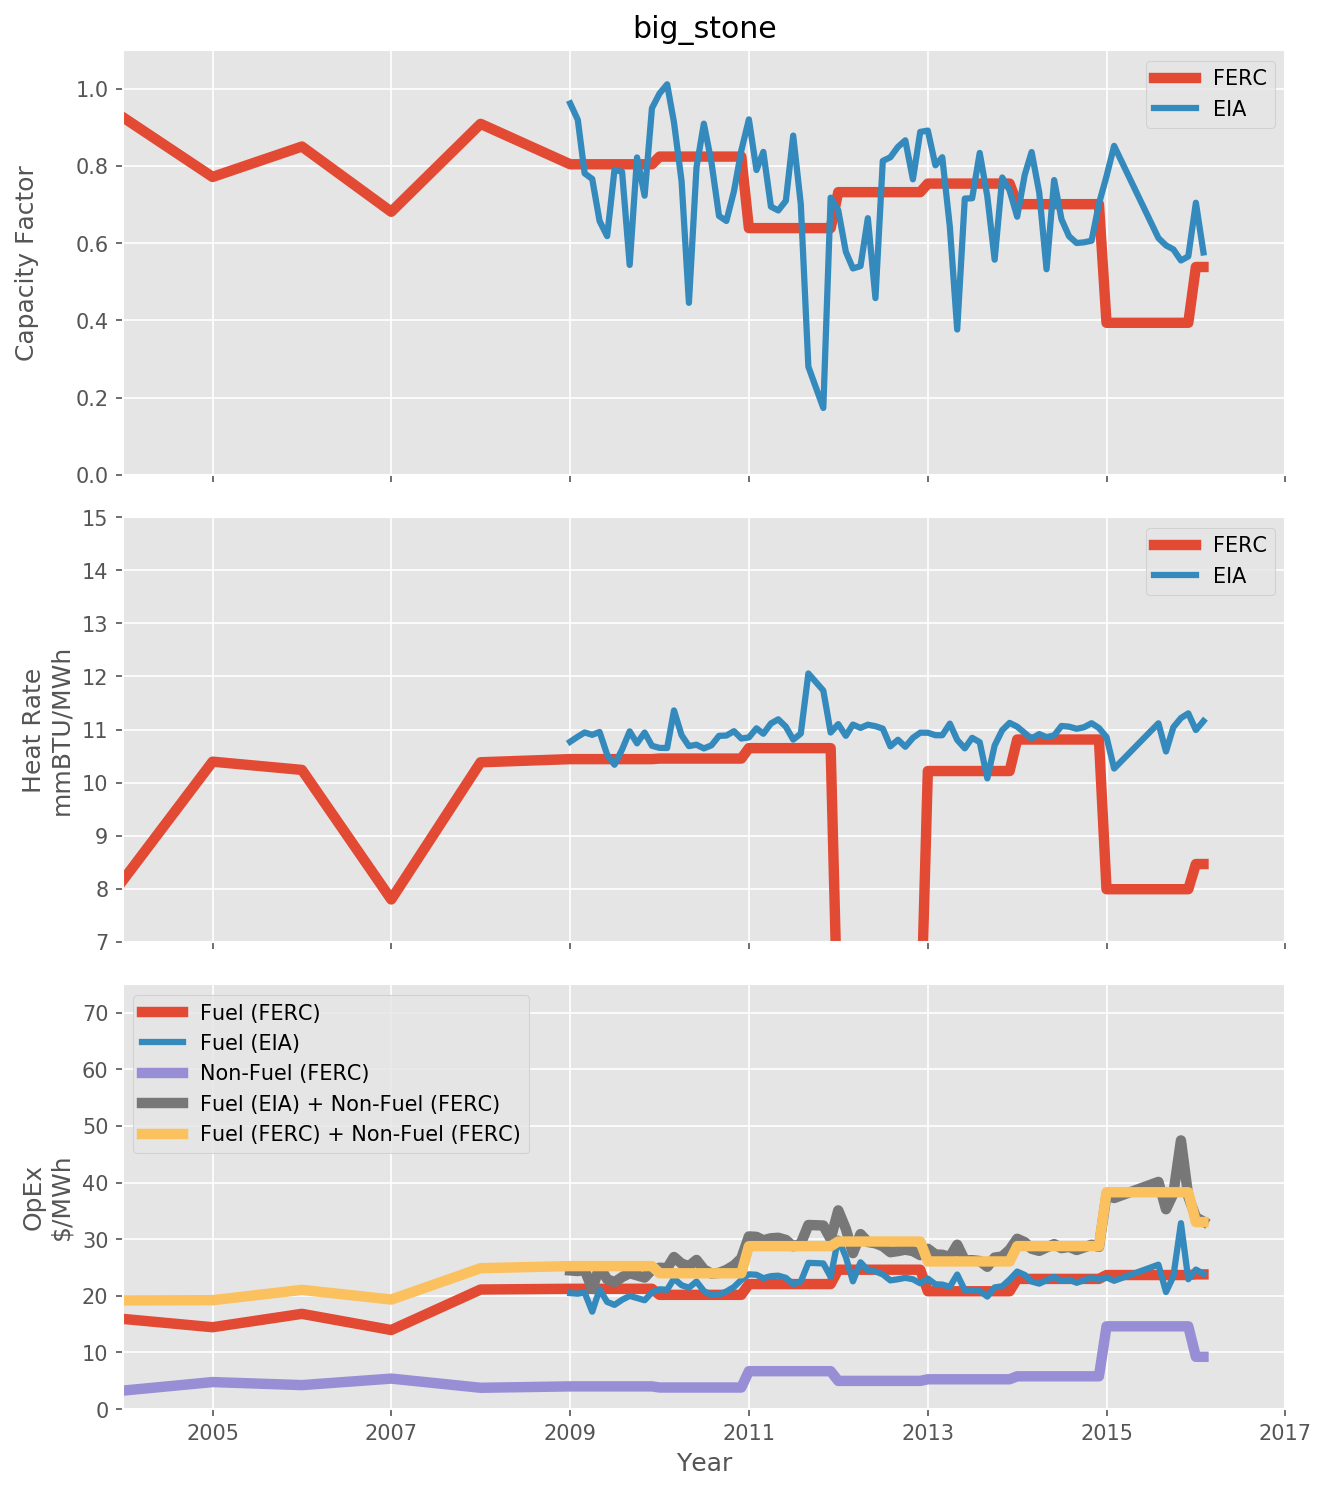

In [22]:
plant = 'big_stone'
plot_ferc_eia_byunit_date(plant, ces_out)

## Grab the coal delivery data to output

In [23]:
ces_plants_eia = ces_out.plant_id_eia.dropna().astype(int).unique()
raw_frc_eia923 = outputs.fuel_receipts_costs_eia923(start_date='2009-01-01',
                                                    end_date='2016-12-31')
ces_raw_frc_eia923 = raw_frc_eia923[raw_frc_eia923.plant_id_eia.isin(ces_plants_eia)]

coal_delivery_cols = [
    'report_date',
    'plant_id_eia',
    'plant_id_pudl',
    'plant_name',
    'operator_id',
    'util_id_pudl',
    'operator_name',
    'supplier',
    'contract_expiration_date',
    'contract_type',
    'energy_source',
    'fuel_type_pudl',
    'primary_transportation_mode',
    'fuel_cost_per_mmbtu',
    'fuel_quantity',
    'heat_content_mmbtu_per_unit',
    'total_fuel_cost',
    'total_heat_content_mmbtu'
]
ces_coal_deliveries = ces_raw_frc_eia923[ces_raw_frc_eia923.fuel_type_pudl=='coal'][coal_delivery_cols]
ces_coal_deliveries.rename(columns={
    'operator_id': 'utility_id_eia',
    'operator_name': 'utility_name'
}, inplace=True)

## Grab all PJM Coal Generator Data

In [24]:
coal_gens_cols = [
    'report_date',
    'plant_id_eia',
    'plant_name',
    'operator_id',
    'operator_name',
    'generator_id',
    'balancing_authority_code',
    'county',
    'fuel_type_pudl',
    'latitude',
    'longitude',
    'minimum_load_mw',
    'nameplate_capacity_mw',
    'operating_date',
    'planned_retirement_date',
    'retirement_date',
    'sector',
    'sector_name',
    'state',
    'status',
    'technology',
]
coal_gens_out = pudl_out.gens_eia860()[coal_gens_cols]
pjm_coal_mask = (
    (coal_gens_out.fuel_type_pudl=='coal') &
    (coal_gens_out.balancing_authority_code=='PJM') &
    (coal_gens_out.report_date.dt.year==2016)
)
pjm_coal_out = coal_gens_out[pjm_coal_mask]
pjm_coal_out = pjm_coal_out[coal_gens_cols]
len(pjm_coal_out)

354

## Output the plant MCOE & coal delivery information.

In [25]:
import datetime
dtstr = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
ces_writer = pd.ExcelWriter('CES_CoalTargets_{}.xlsx'.format(dtstr), engine='xlsxwriter')
ces_out.to_excel(ces_writer, sheet_name='Summary', index=False)

ferc_out = ferc_out.set_index(['ces_label', 'ferc_label', 'report_year'])
ferc_out = ferc_out.reset_index()
ferc_out.to_excel(ces_writer, sheet_name='FERC Source Data', index=False)

eia_out = eia_out.set_index(['ces_label', 'eia_label', 'report_year'])
eia_out = eia_out.reset_index()
eia_out.to_excel(ces_writer, sheet_name='EIA Source Data', index=False)

ces_coal_deliveries.to_excel(ces_writer, sheet_name='Coal Deliveries', index=False)

pjm_coal_out.to_excel(ces_writer, sheet_name='All PJM Coal Generators', index=False)

ces_writer.save()

## BELOW HERE IS SCRATCH PAPER


In [26]:
target_lbas = ['SPP', 'MISO', 'WECC', 'PSCO', 'WACM', 'SWPP',
               'NEVP', 'PNM', 'BPAT', 'ASPS', 'PACE', 'LDWP']
target_states = ['ND', 'SD', 'OK',  'NE', 
                 'KS', 'MN', 'MT', 'WY', 'NM',
                 'NV', 'ID', 'UT', 'WA', 'OR']

not_westerny = ['MO', 'LA','AR','IA',]

In [27]:
eia_df[eia_df.state.isin(target_states)]\
    [['balancing_authority_code', 'balancing_authority_name']].\
    drop_duplicates().set_index('balancing_authority_code').dropna()

,balancing_authority_name
balancing_authority_code,
NPPD,Nebraska Public Power District
SWPP,Southwest Power Pool
WACM,Western Area Power Administration - Rocky Moun...
SECI,Sunflower Electric Power Corporation
GRDA,Grand River Dam Authority
WR,Westar Energy
KCPL,Kansas City Power & Light Company
KACY,Board Of Public Utilities (Kansas City KS)
MISO,Midcontinent Independent Transmission System O...


In [28]:
potential_targets = eia_df[(eia_df.report_year >= 2015) &
       (eia_df.fuel_type_pudl=='coal') &
       #(eia_df.balancing_authority_code.isin(target_lbas)) &
       (eia_df.state.isin(target_states)) & 
       (eia_df.capacity_factor <= 0.70) &
       #(eia_df.capacity_factor >= 0.10) &
       (eia_df.fuel_cost_per_mwh > 21.0) &
       #(eia_df.planned_retirement_date.isnull()) &
       (eia_df.nameplate_capacity_mw > 100.0) ].\
    sort_values(['fuel_cost_per_mwh','nameplate_capacity_mw'], ascending=False)[eia_simple_cols].\
    drop_duplicates('plant_id_eia')

In [29]:
potential_targets = potential_targets.set_index(['plant_id_eia', 'unit_id_pudl', 'report_year'])

In [30]:
potential_targets.drop_duplicates(subset=['plant_name']).count()

plant_name                 33
utility_id                 33
utility_name               33
state                      33
nameplate_capacity_mw      33
fuel_cost_per_mwh          33
capacity_factor            33
planned_retirement_date     3
dtype: int64

In [31]:
potential_targets.head(14)

,,,plant_name,utility_id,utility_name,state,nameplate_capacity_mw,fuel_cost_per_mwh,capacity_factor,planned_retirement_date
plant_id_eia,unit_id_pudl,report_year,,,,,,,,
2442,5,2016,Four Corners,803,Arizona Public Service Co,NM,818.1,inf,0.000000,None
6077,2,2016,Gerald Gentleman,13337,Nebraska Public Power District,NE,681.3,inf,0.000000,None
6106,1,2015,Boardman,15248,Portland General Electric Co,OR,642.2,inf,0.000000,2021-01-01
8066,4,2016,Jim Bridger,14354,PacifiCorp,WY,608.3,inf,0.000000,None
2952,2,2016,Muskogee,14063,Oklahoma Gas & Electric Co,OK,572.0,inf,0.000000,None
8224,1,2015,North Valmy,17166,Sierra Pacific Power Co,NV,277.2,377.560415,0.016748,2021-12-01
56786,1,2015,Spiritwood Station,7570,Great River Energy,ND,106.2,117.388908,0.102844,None
1250,2,2016,Lawrence Energy Center,22500,Westar Energy Inc,KS,114.0,81.620147,0.010010,None
8069,2,2015,Huntington,14354,PacifiCorp,UT,496.0,62.195910,0.002661,None


In [32]:
eia_ids = [56786, 51]
dont_pull = [2324, #RG is already closed
             2451, # SJ is already closed
             2161, #James River Power Station is gas and closing 
             165, # biomass plant
             6190, # Rodemacher
            ]